In [98]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

# 1) Load Week 3/4 enriched GeoJSON
gdf = gpd.read_file("../Week_3/h3_elasticity_clusters.geojson")   # fill: Week 3/4 enriched filename
print("Rows:", len(gdf))


# 2) Basic cleaning: drop rows missing core columns
gdf = gdf.dropna(subset=["trips_sum", "price_mean", "elasticity_estimate"])  # e.g., trips_sum, price_mean, elasticity_estimate
print("Rows after drop:", len(gdf))

# 3) Feature engineering
# Create simple features: trips_sum (lag), price_mean, cluster (as numeric), optionally hour/day
X_cluster = pd.get_dummies(gdf["moran_cluster"], prefix="cluster", drop_first=True)
gdf["price_per_trip"] = gdf["price_mean"] / (gdf["trips_sum"] + 1)  # avoid div0

# 4) Prepare X, y
FEATURES = ["price_mean", "elasticity_estimate", "price_per_trip"]  # fill: trips_sum, price_mean, cluster_code, price_per_trip
X = pd.concat([gdf[FEATURES], X_cluster], axis=1).apply(pd.to_numeric, errors="coerce")
feature_cols = X.columns.tolist()
y = gdf["trips_sum"].values  # fill: target variable (e.g., trips_sum)

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2025)

# 6) Train a Random Forest
model = RandomForestRegressor(n_estimators=200, random_state=2025)
model.fit(X_train, y_train)

# 7) Evaluate model
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)  # squared=False gives RMSE
r2 = r2_score(y_test, preds)
print(f"RMSE: {rmse:.3f}, R2: {r2:.3f}")

# 8) Save baseline predictions to GeoDataFrame
gdf["pred_trips_baseline"] = model.predict(X.values)

# RMSE of 10.423 means predictions are on average about 10 trips from the actual
# R squared of 0.786 means model explains about 79% of variance in trips_sum

Rows: 15
Rows after drop: 15
RMSE: 10.423, R2: 0.786


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saved predictions and recommendations


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


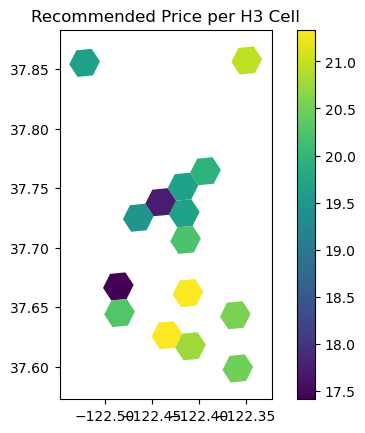

In [101]:
# 9) Counterfactual simulation: try three price options: -10%, baseline, +10%
# 10 percent lower, baseline, 10 percent higher prices. Stores predicted trips for each case. 
price_factors = [0.9, 1.0, 1.1]  # fill: 0.9, 1.0, 1.1
for factor in price_factors:
    col_price = f"price_{int(factor*100)}"
    col_pred = f"pred_trips_{int(factor*100)}"
    # create feature matrix with adjusted price
    X_sim = gdf[FEATURES].copy()
    
    X_sim["price_mean"] = gdf["price_mean"] * factor
    # recompute derived features if needed
    X_sim["price_per_trip"] = X_sim["price_mean"] / (gdf["trips_sum"] + 1)  # fill: trips_sum
    
    X_sim_full = pd.concat([X_sim, X_cluster], axis=1)
    X_sim_full = X_sim_full.reindex(columns=feature_cols, fill_value=0)
    
    gdf[col_price] = X_sim["price_mean"]
    gdf[col_pred] = model.predict(X_sim_full.values)

# 10) Compute revenue = price * predicted_trips and choose best factor.
# Computes price x trips (which is revenue) for each scenario. 
for factor in price_factors:
    col_price = f"price_{int(factor*100)}"
    col_pred = f"pred_trips_{int(factor*100)}"
    col_rev = f"rev_{int(factor*100)}"
    gdf[col_rev] = gdf[col_price] * gdf[col_pred]

# find best revenue per cell among tested factors. 
# finds which price scenario maximizes revenue for each h3 cell. Saves best price. 
rev_cols = [f"rev_{int(f*100)}" for f in price_factors]
gdf["best_rev_col"] = gdf[rev_cols].idxmax(axis=1)
# Map to corresponding price column
price_map = {f"rev_{int(f*100)}": f"price_{int(f*100)}"
    for f in price_factors}
gdf["best_price"] = [gdf.at[idx, price_map[rev_col]]
    for idx, rev_col in gdf["best_rev_col"].items()]
 # might need np indexing

# 11) Save outputs
gdf.to_file("price_counterfactuals.geojson", driver="GeoJSON")  # fill: output geojson filename
gdf[["h3_origin", "best_price", "best_rev_col"]].to_csv("price_recommendations.csv", index=False)  # fill: h3_origin, best_price, best_rev_col, csv filename
print("Saved predictions and recommendations")

# 12) Visualize recommended price on map
gdf.plot(column="best_price", legend=True)  # fill: best_price
plt.title("Recommended Price per H3 Cell")  # fill: Recommended Price per H3 Cell
plt.show()